In [64]:
import pims
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import time
from scipy.stats import skew
from scipy.sparse.linalg import eigsh
from FaceMap import utils, facemap

filenames = ['D:/cams5/mouse_face.mp4']

video = pims.Video(filenames[0])

In [25]:
# get subsampled mean across frames
# grab up to 2000 frames to average over for mean

# number of frames in the movie
nframes = len(video)
nf = min(2000, nframes)

# load in chunks of up to 200 frames (for speed)
nt0 = min(200, nframes)
nsegs = int(np.floor(nf / nt0))

# what times to sample
tf = np.floor(np.linspace(0, nframes - nt0, nsegs)).astype(int)

Ly = video.frame_shape[0]
Lx = video.frame_shape[1]
avgframe = np.zeros((Ly, Lx), np.float32)
avgmotion = np.zeros((Ly, Lx), np.float32)

ns = 0
for n in range(nsegs):
    t = tf[n]
    im = np.array(video[t:t+nt0])
    # im is TIME x Ly x Lx x 3 (3 is RGB)
    if im.ndim > 3:
        im = im[:,:,:,0]
    # most movies have integer values
    # convert to float to average
    im = im.astype(np.float32)
    
    # add to averages
    avgframe += im.mean(axis=0)
    immotion = np.abs(np.diff(im, axis=0))
    avgmotion += immotion.mean(axis=0)
    ### avgframe += ???
    ### immotion = ???
    ### avgmotion += ???
    ns+=1

avgframe /= float(ns)
avgmotion /= float(ns)

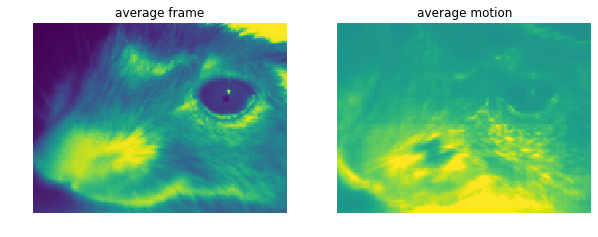

In [36]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(avgframe)
plt.title('average frame')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(avgmotion, vmin=-10, vmax=10)
plt.title('average motion')
plt.axis('off')
plt.show()

In [105]:
# compute incremental SVD across frames
# load chunks of 1000 and take 250 PCs from each
# then concatenate and take SVD of compilation of 250 PC chunks
# number of components kept from SVD is ncomps
ncomps = 1000

nt0 = min(1000, nframes) # chunk size
nsegs = int(min(np.floor(25000 / nt0), np.floor(nframes / nt0)))
nc = 250 # <- how many PCs to keep in each chunk

# what times to sample
tf = np.floor(np.linspace(0, nframes-nt0-1, nsegs)).astype(int)

# giant U that we will fill up with smaller SVDs
U = np.zeros((Ly*Lx, nsegs*nc), np.float32)

for n in range(nsegs):
    t = tf[n]
    im = np.array(video[t:t+nt0])
    # im is TIME x Ly x Lx x 3 (3 is RGB)
    if im.ndim > 3:
        im = im[:,:,:,0]
    # most movies have integer values
    # convert to float to average
    im = im.astype(np.float32)

    immotion = np.abs(np.diff(im, axis=0))
    immotion -= avgmotion[np.newaxis, :, :]
    ### immotion = ???
    # subtract off average motion
    ### immotion -= ???
    
    # flatten immotion so it's TIME x PIXELS
    immotion = np.reshape(immotion, (nt0-1, Ly*Lx))
    immotion = immotion.T
    # take SVD
    USV = utils.svdecon(immotion, k=nc)
    ### USV = ???
    
    U[:, n*nc:(n+1)*nc] = USV[0]

# take SVD of concatenated spatial PCs
### USV = ???
USV = utils.svdecon(U, k=ncomps)
U = USV[0]

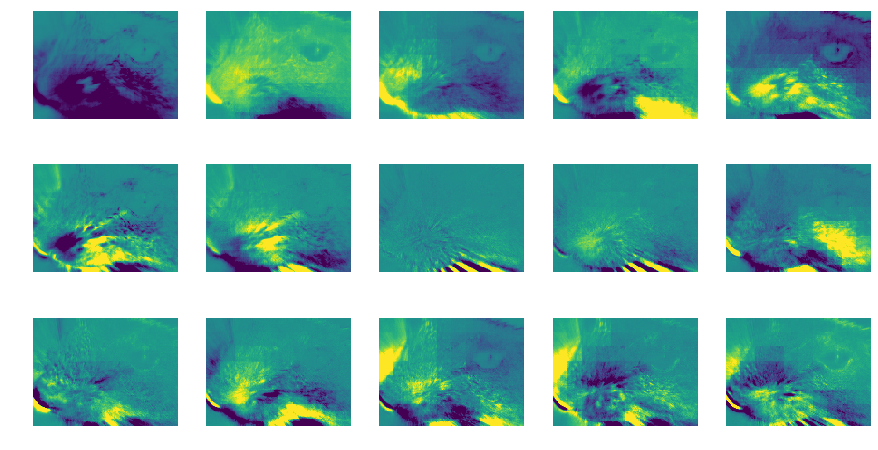

In [47]:
motMask = np.reshape(U, (Ly, Lx, ncomps))
plt.figure(figsize=(15,8))
for i in range(15):
    ax=plt.subplot(3,5,i+1)
    ax.imshow(motMask[:,:,i] / motMask[:,:,i].std(), vmin=-2, vmax=2)
    ax.axis('off')
plt.show()

In [106]:
### when do these spatial PCs occur in time?
# project spatial PCs onto movies (in chunks again)

ncomps = U.shape[1]
nt0 = min(1000, nframes) # chunk size
nsegs = int(np.ceil(nframes / nt0))

# time ranges
itimes = np.floor(np.linspace(0, nframes, nsegs+1)).astype(int)

# projection of spatial PCs onto movie
motSVD = np.zeros((nframes, ncomps), np.float32)

for n in range(nsegs):
    im = np.array(video[itimes[n]:itimes[n+1]])
    # im is TIME x Ly x Lx x 3 (3 is RGB)
    if im.ndim > 3:
        im = im[:,:,:,0]
    # most movies have integer values
    # convert to float to average
    im = im.astype(np.float32)

    # we need to keep around the last frame for the next chunk
    imend = im[-1,:]    
    if n>0:
        im = np.concatenate((imend[np.newaxis,:], im), axis=0)
    else:
        # if it's the first chunk, just add in the second time point
        # (this will make the first two timepoints the same)
        im = np.concatenate((im[1,:][np.newaxis,:], im), axis=0)
    
    immotion = np.abs(np.diff(im, axis=0))
    immotion -= avgmotion[np.newaxis, :, :]
    ### immotion = ???
    # subtract off average motion
    ### immotion -= ???
    
    # flatten immotion so it's TIME x PIXELS
    immotion = np.reshape(immotion, (-1, Ly*Lx))
    
    # project U onto immotion
    V = immotion @ U
    ### V = ????
    
    motSVD[itimes[n]:itimes[n+1], :] = V


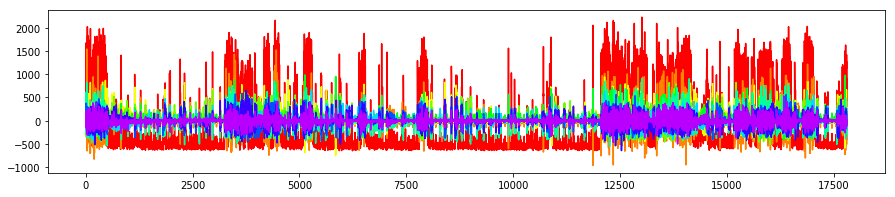

In [68]:
plt.figure(figsize=(15,3))
# flip traces
if False:
    motSVD *= np.sign(skew(motSVD, axis=0))[np.newaxis,:]
cmap = cm.get_cmap('hsv')
cmap = cmap(np.linspace(0,.8,10))
for n in range(10):
    plt.plot(motSVD[:,n], color=cmap[n,:])
plt.show()

In [82]:
# let's take this 500-dimensional representation and reduce it with Rastermap
from rastermap import Rastermap

model = Rastermap(n_components=2, n_X=20)
y = model.fit_transform(motSVD)


time; iteration;  explained PC variance
0.40s     0        0.4464
4.32s    10        0.6631
8.38s    20        0.6911
12.68s    30        0.7037
17.23s    40        0.7017
19.50s   final      0.7033
19.80s upsampled    0.7923


<IPython.core.display.Javascript object>


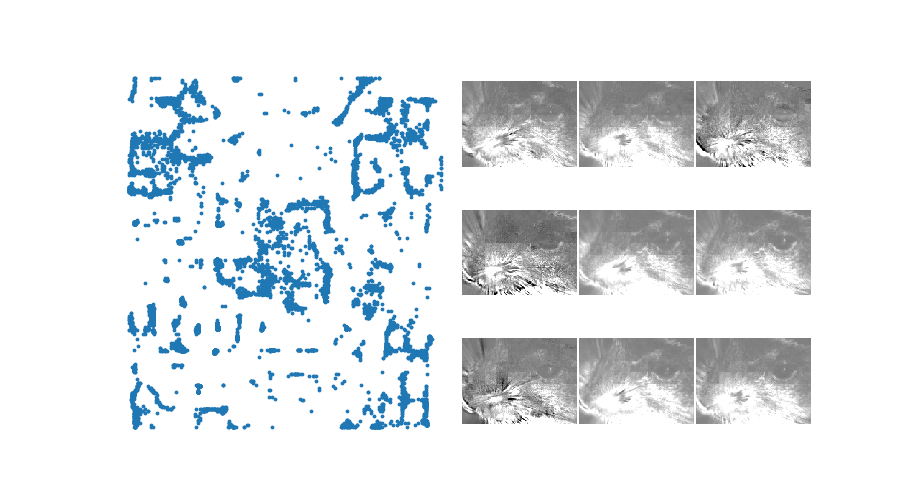

In [104]:
from importlib import reload
reload(plt)
%matplotlib notebook

# create figure and plot scatter

# create the annotations box
#im = OffsetImage(img0[0,:,:])
fig, axes = plt.subplots(3,6, figsize=(9,5))
fig.subplots_adjust(hspace=0.01, wspace=0.02)
for ni in range(3):
    for nj in range(6):
        axes[ni,nj].axis('off')

ax = fig.add_subplot(1,2,1)
ax.scatter(y[:,0],y[:,1], s=3)
ax.axis('off')
    
def onclick(event):
    # if the mouse is over the scatter points
    #if line.contains(event)[0]:
    # find out the index within the array from the event
    dists = (y[:,0]-event.xdata)**2 + (y[:,1]-event.ydata)**2
    inds = dists.argsort()[:12]
    face = motSVD[inds,:] @ U.T
    face /= face.std(axis=1)[:,np.newaxis]
    face = np.reshape(face, (-1,Ly,Lx))
            
    for ni in range(3):
        for nj in range(3):
            axes[ni,nj+3].imshow(face[ni+nj*3,:,:],plt.get_cmap('gray'),vmin=-2,vmax=2)
            axes[ni,nj+3].axis('off')
    plt.show()
    #fig.canvas.draw_idle()

# add callback for mouse moves
fig.canvas.mpl_connect('button_press_event', onclick)           
plt.show()
